# Residual Networks

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

## Load Packages

In [7]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from resnets_utils import *
from matplotlib.pyplot import imshow
%matplotlib inline

## Identity Block

In [ ]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    #first component of main path
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    #second component of main path
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    #third component of main path
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    #Final Step
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

## Convolutional Block

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    #first component of main path
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    #second component of main path
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    #third component of main path
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    #Shortcut Path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    
    #Final Step
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Building ResNet Model (50 Layers)

<img src="https://github.com/aitezazakhtar/ResNet50_SignDataset/blob/master/images/resnet_kiank.png?raw=1" style="width:850px;height:150px;">

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three sets of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three sets of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The 'flatten' layer doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

In [ ]:
def ResNet50(input_shape, classes):
    
    X_input = Input(input_shape)
    
    #Zero Padding
    X = ZeroPadding2D((3,3))(X_input)
    
    #Stage1
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = MaxPooling2D((3,3), strides = (2,2))(X)
    
    #Stage2
    X = convolutional_block(X, 3, [64,64,256], stage = 2, block = 'a', s = 1)
    X = identity_block(X, 3, [64,64,256], stage = 2, block= 'b')
    X = identity_block(X, 3, [64,64,256], stage = 2, block= 'c')
    
    #Stage3
    X = convolutional_block(X, 3, [128,128,512], 3, 'a', 2)
    X = identity_block(X, 3, [128,128,512], 3, 'b')
    X = identity_block(X, 3, [128,128,512], 3, 'c')
    X = identity_block(X, 3, [128,128,512], 3, 'd')
    
    #Stage4
    X = convolutional_block(X, 3, [256,256,1024], 4, 'a', 2)
    X = identity_block(X, 3, [256,256,1024], 4, 'b')
    X = identity_block(X, 3, [256,256,1024], 4, 'c')
    X = identity_block(X, 3, [256,256,1024], 4, 'd')
    X = identity_block(X, 3, [256,256,1024], 4, 'e')
    X = identity_block(X, 3, [256,256,1024], 4, 'f')
    
    #Stage5
    X = convolutional_block(X, 3, [512,512,2048], 5, 'a', 2)
    X = identity_block(X, 3, [512,512,2048], 5, 'b')
    X = identity_block(X, 3, [512,512,2048], 5, 'c')
    
    #AveragePool
    X = AveragePooling2D((2,2), padding = 'same')(X)
    
    #Output Layer
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    #Create Model
    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')
    
    return model

In [ ]:
model = ResNet50(input_shape = (64,64,3), classes = 6)

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Dataset

The model is now ready to be trained. Let's load the SIGNS Dataset.
<img src="https://github.com/aitezazakhtar/ResNet50_SignDataset/blob/master/images/signs_data_kiank.png?raw=1" style="width:450px;height:250px;">

In [9]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [ ]:
model.fit(X_train, Y_train, epochs = 50, batch_size = 32)

Epoch 1/50
34/34 [==============================] - 34s 89ms/step - loss: 2.7550 - accuracy: 0.3833
Epoch 2/50
34/34 [==============================] - 2s 61ms/step - loss: 0.7342 - accuracy: 0.7601
Epoch 3/50
34/34 [==============================] - 2s 61ms/step - loss: 0.4616 - accuracy: 0.8489
Epoch 4/50
34/34 [==============================] - 2s 61ms/step - loss: 0.3903 - accuracy: 0.8994
Epoch 5/50
34/34 [==============================] - 2s 61ms/step - loss: 0.1803 - accuracy: 0.9495
Epoch 6/50
34/34 [==============================] - 2s 61ms/step - loss: 0.1014 - accuracy: 0.9664
Epoch 7/50
34/34 [==============================] - 2s 61ms/step - loss: 0.1133 - accuracy: 0.9609
Epoch 8/50
34/34 [==============================] - 2s 61ms/step - loss: 0.1504 - accuracy: 0.9557
Epoch 9/50
34/34 [==============================] - 2s 61ms/step - loss: 0.1718 - accuracy: 0.9416
Epoch 10/50
34/34 [==============================] - 2s 61ms/step - loss: 0.1152 - accuracy: 0.9691
Epoch 11

In [ ]:
preds = model.evaluate(X_test, Y_test)

4/4 [==============================] - 4s 29ms/step - loss: 0.1299 - accuracy: 0.9667


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Test our own image

In [6]:
model = load_model('/content/drive/MyDrive/Models/ResNet50.h5')

In [44]:
def pred_sign(image_path):
  img = image.load_img(image_path, target_size = (64,64,3))
  imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255
  pred = np.argmax(model.predict(x))
  print("Sign: ",pred)

Sign:  2


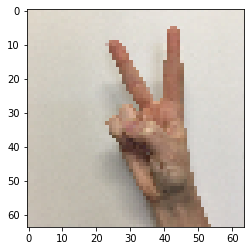

In [45]:
pred_sign('images/my_image.jpg')

Sign:  5


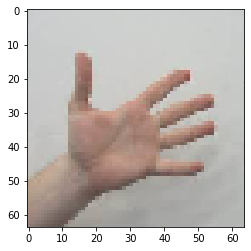

In [46]:
pred_sign('images/images.jpg')